In [104]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import skimage.io as io
import pickle
import os
import glob
import blur
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, square
from skimage.color import label2rgb
from collections import defaultdict

In [ ]:
# From:
# https://www.tensorflow.org/guide/gpu#limiting_gpu_memory_growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)


# Constants
IMG_SIZE = [ 224, 224 ]
kVal = 5    # Top 5

# IMG_DIMS is [ None, IMG_SIZE, 3 ]
IMG_DIMS = [ None ]
IMG_DIMS.extend( IMG_SIZE )
IMG_DIMS.extend( [3] )

# Location of TFRecords
recPath = 'records'
recName = 'ImageNet'


# Display some plots
def testLoad( data, info ):

    plt.figure( figsize=(10,10) )
    i=0
    for image, label in data:

        if i == 25:
            break
        plt.subplot( 5, 5, i+1 )
        plt.xticks([])
        plt.yticks([])
        plt.grid( False )
        plt.imshow( image )
        label = info.features["label"].int2str(label)
        plt.xlabel( label )
        i += 1

    plt.show()


# Read TFRecord file from:
# https://stackoverflow.com/questions/47861084/how-to-store-numpy-arrays-as-tfrecord
def _parse_tfr_element(element):

    parse_dic = {
            'image': tf.io.FixedLenFeature([], tf.string), # Note that it is tf.string, not tf.float32
            'label': tf.io.FixedLenFeature([], tf.string),
            'bbox': tf.io.FixedLenFeature([], tf.string),
    }
    example_message = tf.io.parse_single_example(element, parse_dic)

    b_image = example_message['image'] # get byte string
    b_bbox = example_message['bbox']
    b_label = example_message['label']
    
    img = tf.io.parse_tensor(b_image, out_type=tf.uint8) # restore 2D array from byte string
    bbox = tf.io.parse_tensor(b_bbox, out_type=tf.int32)
    label = tf.io.parse_tensor(b_label, out_type=tf.string)
    label = int(label)

    return img, label, bbox


def normalize_img( image, label, bbox ):
    """Normalizes images: `uint8` -> `float32`."""
    return tf.cast(image, tf.float32) / 255, label, bbox


# Python function to manipulate dataset
def map_func( image, label, bbox ):
    """ Scales images to IMG_SIZE.
        Removes bounding box element of dataset."""

    # Deal with grayscale images
    if len( tf.shape(image) ) == 2:
        image = np.expand_dims( image, axis=-1 )
        image = tf.concat( [image, image, image], axis=-1 )

    image = tf.image.resize( image, IMG_SIZE )

    image = blur.applyBlur( image, IMG_SIZE[0]//2, IMG_SIZE[1]//2, 70 )

    return image, label


# Function to define shape of tfds
def ensureShape( image, label ):

    # dims -> [ IMG_SIZE, 3 ]
    dims = []
    dims.extend( IMG_SIZE )
    dims.extend( [3] )

    image = tf.ensure_shape( image, dims )

    return image, label


def calcAcc( probs, truth, k ):

    numEx = tf.shape( probs )[0]

    correctBools = tf.math.in_top_k( truth[ np.arange( 0,numEx ) ], probs, 5 )
    numCorrect = tf.math.reduce_sum( tf.cast( correctBools, tf.float32 ) )
    print( numCorrect )
    print( numCorrect / tf.cast( numEx, tf.float32 ) )

    return
    

def sortRecs( rec ):

    fileName, _ = rec.split( '.' )
    _, num = fileName.split( '-' )
    return int(num)

    
if __name__ == "__main__":
    
    # Load data
    # Iterate through all images of a specific extension in the specified directory
    fileName = []
    imgPath = os.path.join( recPath, '*.tfrecords' )

    for filepath in glob.iglob( imgPath ):
        fileName.append( filepath )

    # Sort list of tfrecords in numerical ascending order b/c ground truth labels are in that order
    fileName.sort( key=sortRecs )  
    print( fileName )

    tfr_dataset = tf.data.TFRecordDataset(fileName) 
    dataset = tfr_dataset.map(_parse_tfr_element)

    print("\n\n\n\n")
    print( dataset.element_spec )

    # Map dataset
    ds = dataset.map(
        normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    print( ds.element_spec )

    # Map using tf.py_function
    dsFirst = ds.map( lambda image, label, bbox: tf.py_function(func=map_func,
          inp=[image, label, bbox], Tout=[tf.float32, tf.int32]), 
          num_parallel_calls=tf.data.experimental.AUTOTUNE )

    # Set (previously known) shapes of images
    dsFirst = dsFirst.map( 
        ensureShape, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    print( dsFirst.element_spec )

    # for img, label in ds.take(3):
        
    #     fig, ax = plt.subplots()
    #     print( tf.shape( img ) )
    #     print( label )
    #     img = blur.applyBlur( img, 60, 60, 40 )
    #     ax.imshow( img )
    #     plt.show()

    # Load mappings from a file
    with open('INToTf.pkl', 'rb') as f: 
        data = f.read() 
        INToTf = pickle.loads(data) 

    # Load ground truth labels from a file
    with open('truth.pkl', 'rb') as f: 
        data = f.read() 
        truthDict = pickle.loads(data)

    # Load mapped ground truth labels from a file
    with open('truthMapped.pkl', 'rb') as f:
        data = f.read() 
        mappedTruthDict = pickle.loads(data)  
    
    # Use mappings to get the correct labels
    mappedTruthDict = { k:v[0] for (k,v) in mappedTruthDict.items() }
    truth = np.array( list( mappedTruthDict.values() ) )

In [ ]:
# Map using tf.py_function
dsFirst = ds.map( lambda image, label, bbox: tf.py_function(func=map_func,
        inp=[image, label, bbox], Tout=[tf.float32, tf.int32]), 
        num_parallel_calls=tf.data.experimental.AUTOTUNE )

# Set (previously known) shapes of images
dsFirst = dsFirst.map( 
    ensureShape, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [ ]:
# Load pre-trained model
# Do not use softmax b/c want the raw scores
model = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/imagenet/inception_v1/classification/4"),
])
model.build( IMG_DIMS )  # Batch input shape
model.summary()

In [ ]:
# Get saliency map for top-k-th prediction
topLabel = 0

# Percentile for saliency map
theta = 0.7*100 # Original paper suggested .95

# Loss function
bce = tf.keras.losses.BinaryCrossentropy()

for input, label in dsFirst.take(1):
    
    input = tf.reshape( input, [1, 224, 224, 3] )
    image = tf.Variable( input )

    with tf.GradientTape() as tape:

        # Watch the input image to compute saliency map later
        tape.watch(image)

        # Forward-pass to get initial predictions
        probs = model( image )

        # Get top-k predictions
        _, preds = tf.math.top_k(probs, k=kVal) # Throw out the probs for each top prediction (included in probs variable)
        #print( preds[0] )
        true = tf.one_hot( preds[0][topLabel], len( probs[0] )  )  # One-hot encode the predictions to the same size as probs

        loss = bce( probs, true )
        #print( loss )

    grads = abs( tape.gradient( loss, image ) )
    grads = tf.reduce_max( grads[0], axis=-1 )
    print( np.max( grads ) )
    
    #thres = tfp.stats.percentile( grads, q=theta )
    thres = 0.7 * np.max( grads )
    grads = tf.keras.activations.relu( grads, threshold=thres )
    print( grads )
    print( tf.math.count_nonzero(grads))
    plt.imshow( grads, cmap="gray" )
    plt.show()

In [ ]:
for image, label in dsFirst.take(1):

    image = tf.reshape( image, [1, 224, 224, 3] )
    probs = model.predict( image )
    
    # Get top-k predictions
    _, preds = tf.math.top_k(probs, k=kVal)
    print(preds)
    plt.imshow( image[0] )
    plt.show()

In [ ]:
dataDir = 'images'
fileName = 'ILSVRC2012_val_00039843.JPEG'
I = io.imread( '%s/%s'%(dataDir,fileName) )
plt.imshow(I)
plt.show()

In [ ]:
topLabel = 0

img = I
img = tf.image.resize( img, IMG_SIZE )
img = img / 255
img = blur.applyBlur( img, 112, 112, 70 )
img = tf.reshape( img, [1, 224, 224, 3] )
image = tf.Variable( img )

# Loss function
bce = tf.keras.losses.BinaryCrossentropy( from_logits=True )

with tf.GradientTape() as tape:

    # Watch the input image to compute saliency map later
    tape.watch( image )

    # Forward-pass to get initial predictions
    probs = model( image )

    # Get top-k predictions
    _, preds = tf.math.top_k(probs, k=kVal) # Throw out the probs for each top prediction (included in probs variable)
    print( preds )
    true = tf.one_hot( preds[0], len( probs[0] )  )  # One-hot encode the predictions to the same size as probs
    print(true)
    loss = bce( probs[0], true[topLabel] )
    print( loss )

grads = abs( tape.gradient( loss, image ) )
grads = tf.reduce_max( grads[0], axis=-1 )
#print( np.max( grads ) )



# grads = grads / np.max(grads)
# thres = 0.5
plt.imshow( grads, cmap="gray" )
plt.show()
thres = tfp.stats.percentile( grads, q=80 )
grads = tf.keras.activations.relu( grads, threshold=thres )
plt.imshow( grads, cmap="gray" )
plt.show()
# # Create the bounding box
# where = tf.not_equal( grads, 0 )
# indices = tf.where(where)
# xVals = [ temp[1] for temp in indices ]
# yVals = [ temp[0] for temp in indices ]
# xmin = tf.reduce_min( xVals )
# xmax = tf.reduce_max( xVals )
# ymin = tf.reduce_min( yVals )
# ymax = tf.reduce_max( yVals )

# # print( grads )
# # print( tf.math.count_nonzero(grads))
# # print( xmin,xmax,ymin,ymax)
# fig, ax = plt.subplots()
# plt.imshow( grads, cmap="gray" )
# ax.add_patch( patches.Rectangle( (xmin, ymin), xmax-xmin, ymax-ymin, fill=False, color='r' ) )
# plt.show()
# fig, ax = plt.subplots()
# plt.imshow( img[0] )
# ax.add_patch( patches.Rectangle( (xmin, ymin), xmax-xmin, ymax-ymin, fill=False, color='r' ) )
# plt.show()

In [ ]:
image = grads.numpy()
# apply threshold

# thres = tfp.stats.percentile(grads, q=90 )
thres = threshold_otsu(image)
bw = closing(image > thres, square(3))

# remove artifacts connected to image border
# cleared = clear_border(bw)

# label image regions
label_image = label(bw)
# to make the background transparent, pass the value of `bg_label`,
# and leave `bg_color` as `None` and `kind` as `overlay`
image_label_overlay = label2rgb(label_image, image=image, bg_label=0)

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image_label_overlay)

for region in regionprops(label_image):
    # take regions with large enough areas
    if region.area >= 100:
        # draw rectangle around segmented coins
        minr, minc, maxr, maxc = region.bbox
        rect = patches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                  fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)

ax.set_axis_off()
plt.tight_layout()
plt.show()

In [ ]:
curMaxArea = 0

# Get max region
for region in regionprops(label_image):
    
    if region.area >= curMaxArea:

        curMaxArea = region.area
        maxRegion = region

In [ ]:
fig, ax = plt.subplots()
plt.imshow( grads, cmap="gray" )

minr, minc, maxr, maxc = maxRegion.bbox
rect = patches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                            fill=False, edgecolor='red', linewidth=2)
ax.add_patch(rect)

plt.show()

fig, ax = plt.subplots()
plt.imshow( img[0] )
ax.add_patch( patches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                            fill=False, edgecolor='red', linewidth=2) )
plt.show()

In [ ]:
# Second pass
height = maxc - minc
width = maxr - minr
f_new = np.floor( np.max( [height, width] ) / 2 )
f_new = np.max( [30, f_new] )
centerX = minc + height/2
centerY = minr + width/2
print( f_new )
imgSec = I
imgSec = tf.image.resize( imgSec, IMG_SIZE )
imgSec = imgSec / 255
imgSec = blur.applyBlur( imgSec, centerX, centerY, f_new )

# Show image
fig, ax = plt.subplots()
plt.imshow( imgSec )
ax.add_patch( patches.Circle( (centerX, centerY), f_new, fill=False, color='r' ) )
plt.show()
imgSec = tf.reshape( imgSec, [1, 224, 224, 3] )


In [ ]:
logits = model.predict( imgSec )
_, preds = tf.math.top_k(logits, k=kVal)

print( preds )


In [ ]:
Original: [315 308 313 304 319]
[304 313 308 315  71]
[927 926 810 470 910]
[634 819 972 713 899]
[938 311 819 927 910]

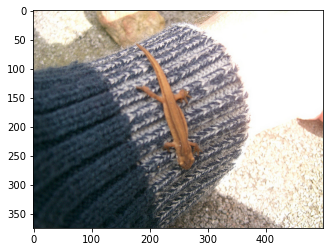

In [157]:
dataDir = 'images'
fileName = 'ILSVRC2012_val_00029622.JPEG'
I = io.imread( '%s/%s'%(dataDir,fileName) )
plt.imshow(I)
plt.show()

img = I
img = tf.image.resize( img, IMG_SIZE )
img = img / 255
img = blur.applyBlur( img, 112, 112, 70 )
img = tf.reshape( img, [1, 224, 224, 3] )
imageVar = tf.Variable( img )

86.0


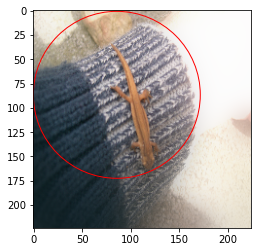





81.0


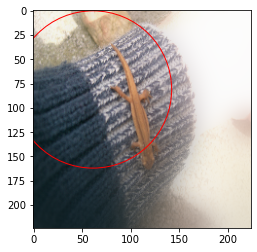





107.0


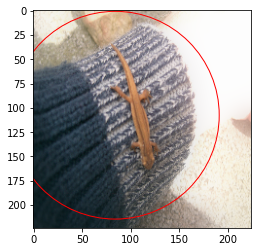





112.0


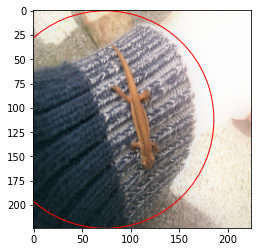





87.0


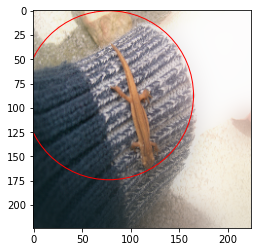

In [158]:
topK = 5
topKOri = np.zeros( [1,topK] )
topKSq = np.zeros( [topK,topK] )
confs = np.zeros( [topK,topK] )

# Loss function
bce = tf.keras.losses.BinaryCrossentropy( from_logits=True )

for topLabel in range(topK):

    with tf.GradientTape() as tape:

        # Watch the input image to compute saliency map later
        tape.watch( imageVar )

        # Forward-pass to get initial predictions
        probs = model( imageVar )

        # Get top-k predictions
        _, preds = tf.math.top_k(probs, k=kVal) # Throw out the probs for each top prediction (included in probs variable)
        topKOri = preds

        true = tf.one_hot( preds[0], len( probs[0] )  )  # One-hot encode the predictions to the same size as probs

        loss = bce( probs[0], true[topLabel] )


    grads = abs( tape.gradient( loss, imageVar ) )
    grads = tf.reduce_max( grads[0], axis=-1 )

    thres = tfp.stats.percentile( grads, q=80 )
    grads = tf.keras.activations.relu( grads, threshold=thres )
    # plt.imshow( grads, cmap="gray" )
    # plt.show()

    image = grads.numpy()

    # apply threshold
    thres = threshold_otsu(image)
    bw = closing(image > thres, square(3))

    # label image regions
    label_image = label(bw)
    # to make the background transparent, pass the value of `bg_label`,
    # and leave `bg_color` as `None` and `kind` as `overlay`
    image_label_overlay = label2rgb(label_image, image=image, bg_label=0)

    # fig, ax = plt.subplots(figsize=(10, 6))
    # ax.imshow(image_label_overlay)

    # for region in regionprops(label_image):
    #     # take regions with large enough areas
    #     if region.area >= 100:
    #         # draw rectangle around segmented coins
    #         minr, minc, maxr, maxc = region.bbox
    #         rect = patches.Rectangle((minc, minr), maxc - minc, maxr - minr,
    #                                 fill=False, edgecolor='red', linewidth=2)
    #         ax.add_patch(rect)

    # ax.set_axis_off()
    # plt.tight_layout()
    # plt.show()

    curMaxArea = 0

    # Get max region
    for region in regionprops(label_image):
        
        if region.area >= curMaxArea:

            curMaxArea = region.area
            maxRegion = region

    # Visualize
    # fig, ax = plt.subplots()
    # plt.imshow( grads, cmap="gray" )

    minr, minc, maxr, maxc = maxRegion.bbox
    # rect = patches.Rectangle((minc, minr), maxc - minc, maxr - minr,
    #                             fill=False, edgecolor='red', linewidth=2)
    # ax.add_patch(rect)

    # plt.show()

    # fig, ax = plt.subplots()
    # plt.imshow( img[0] )
    # ax.add_patch( patches.Rectangle((minc, minr), maxc - minc, maxr - minr,
    #                             fill=False, edgecolor='red', linewidth=2) )
    # plt.show()

    # Second pass
    height = maxc - minc
    width = maxr - minr
    f_new = np.floor( np.max( [height, width] ) / 2 )
    f_new = np.max( [30, f_new] )   # Minimum foveal size
    centerX = minc + height/2
    centerY = minr + width/2
    print( f_new )
    imgSec = I
    imgSec = tf.image.resize( imgSec, IMG_SIZE )
    imgSec = imgSec / 255
    imgSec = blur.applyBlur( imgSec, centerX, centerY, f_new )

    # Show image
    fig, ax = plt.subplots()
    plt.imshow( imgSec )
    ax.add_patch( patches.Circle( (centerX, centerY), f_new, fill=False, color='r' ) )
    plt.show()
    imgSec = tf.reshape( imgSec, [1, 224, 224, 3] )

    logits = model.predict( imgSec )
    conf, preds = tf.math.top_k(logits, k=kVal)
    confs[ topLabel ] = conf
    topKSq[ topLabel ] = preds

    print( "\n\n\n" )


In [159]:
# Map top-k into dicts
dicts = []
for i in range( topK ):
    dicts.append( dict( zip( topKSq[i], confs[i] ) ) )

# Get the highest confidences for each unique label
dictTopK = defaultdict(int)
dictTopK.update( dicts[0] )
for i in range(1,topK):
    dictTopK.update( (k,v) for k,v in dicts[i].items() if dictTopK[k] < v )

# Sort the dict in descending order
# Get topK labels
tupleTopK = sorted(dictTopK.items(), key=lambda x: x[1], reverse=True)[:topK]

In [160]:
# Get labels into a list
newTopK = [ int(x[0]) for x in tupleTopK ]
print( dict(dictTopK) )
print( newTopK )
print( topKOri.numpy() )

{817.0: 7.939908027648926, 912.0: 8.529960632324219, 659.0: 7.852931022644043, 807.0: 7.453281879425049, 475.0: 6.58634614944458, 680.0: 5.800699234008789}
[912, 817, 659, 807, 475]
[[817 912 659 807 773]]


In [144]:
print( topKOri.numpy() )
print( topKSq )
print( confs )

[[513 474 624 778 785]]
[[513. 474. 624. 778. 785.]
 [513. 474. 624. 778. 785.]
 [513. 474. 624. 778. 785.]
 [513. 474. 624. 778. 785.]
 [513. 474. 624. 778. 785.]]
[[7.1287322  6.84573889 6.58591223 6.16984606 5.65219927]
 [7.09298372 6.82889557 6.56014109 6.17276001 5.64240456]
 [7.18089151 6.94297695 6.65526915 6.20332861 5.63386679]
 [7.14242077 6.83136129 6.60280323 6.19869804 5.65105343]
 [6.94662571 6.65167618 6.47999287 6.24036503 5.58815527]]
